# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: total: 1.67 s
Wall time: 1.67 s


,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,record,fraud_label
0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
2,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0
3,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0
4,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 13

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'fulladdress_day_since',
 'name_dob_count_30',
 'address_unique_count_for_name_homephone_60',
 'fulladdress_unique_count_for_dob_homephone_3',
 'address_unique_count_for_homephone_name_dob_30',
 'address_unique_count_for_ssn_name_dob_14',
 'address_day_since',
 'address_count_14',
 'address_count_7',
 'address_count_0_by_30',
 'address_unique_count_for_homephone_name_dob_60',
 'fulladdress_count_0_by_30',
 'address_unique_count_for_ssn_zip5_60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0


In [5]:
vars.shape

(1000000, 15)

In [6]:
vars['Fraud'].sum()

14393.0

In [7]:
vars.head(10)

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
5,6.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
6,7.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
7,8.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
8,9.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0
9,10.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0


In [8]:
vars.shape

(1000000, 15)

In [9]:
vars.describe()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754
std,288675.278933,0.119104,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000
25%,250000.750000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000
50%,500000.500000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000
75%,750000.250000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000
max,1000000.000000,1.000000,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754
std,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000
max,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.217728e-16,1.322675e-17,-3.264944e-17,-6.445688e-17,4.465051e-17,-1.564828e-16,5.117329e-17,1.161098e-16,-1.432880e-16,-1.986219e-15,1.431033e-16,3.711753e-15,-9.060841e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.280209e+00,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,-3.053486e+00,-8.860966e-02,-7.268319e-02,-8.752323e+00,-9.920487e-02,-9.942674e+00,-9.115457e-02
25%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02
50%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02
75%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02
max,4.030326e-01,6.630026e+01,4.127016e+01,5.368356e+01,4.512894e+01,4.767899e+01,4.281212e-01,4.683076e+01,4.943321e+01,2.002135e-01,4.111004e+01,1.800485e-01,4.137264e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [19]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 13)

CPU times: total: 422 ms
Wall time: 416 ms


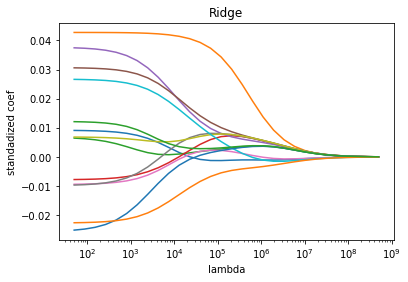

In [20]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [21]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [22]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
CPU times: total: 8min 20s
Wall time: 2min 7s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


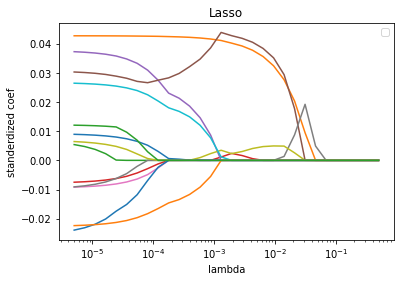

In [23]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [24]:
len(X_trntst.columns)

13

In [25]:
X_trntst_save = X_trntst.copy()

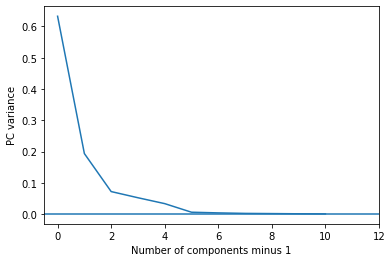

In [26]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [27]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.39111,0.490022,0.127181,-0.139731,-0.039326,0.011427
1,-0.39111,0.490022,0.127181,-0.139731,-0.039326,0.011427
2,-0.39111,0.490022,0.127181,-0.139731,-0.039326,0.011427
3,-0.39111,0.490022,0.127181,-0.139731,-0.039326,0.011427
4,-0.39111,0.490022,0.127181,-0.139731,-0.039326,0.011427


In [28]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
833507,0.216991,-1.820798,-1.522534,1.517953,0.053775,0.020268
833508,-0.391110,0.490022,0.127181,-0.139731,-0.039326,0.011427
833509,2.960622,-7.560635,1.118914,-1.565407,-1.042827,-0.030646
833510,-0.391110,0.490022,0.127181,-0.139731,-0.039326,0.011427
833511,-0.391110,0.490022,0.127181,-0.139731,-0.039326,0.011427


In [29]:
X_trntst.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.031522,-0.001708,-0.000377,0.001320,0.000348,0.000852,0.031615,0.000682,0.001052,0.000987,-0.000473,0.000686,-0.000253
std,0.981263,0.979550,0.996756,1.013675,1.002736,1.008244,0.983233,1.007653,1.011013,0.997512,0.996709,0.998151,0.997370
min,-3.280209,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,-3.053486,-0.088610,-0.072683,-8.752323,-0.099205,-9.942674,-0.091155
25%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155
50%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155
75%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155
max,0.403033,66.300262,41.270156,53.683556,45.128940,47.678988,0.428121,46.830762,49.433212,0.200213,41.110043,0.180049,41.372637


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.044640,-0.194485,-0.122590,0.130219,0.019585,0.000329
std,2.769380,1.637635,1.102153,0.921468,0.730221,0.307797
min,-0.391110,-17.927214,-2.949780,-6.624783,-8.514424,-3.866187
25%,-0.391110,-0.200348,0.051883,-0.139731,-0.039326,0.011427
50%,-0.391110,0.490022,0.127181,-0.139731,-0.039326,0.011427
75%,-0.196820,0.490022,0.127181,-0.139731,-0.033531,0.011427
max,124.464376,34.985390,47.131657,27.040903,35.197066,13.721945


In [31]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [32]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,2.311908e-17,-8.552015e-17,-6.110531e-17,-1.152544e-16,2.369877e-18,-3.171202e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.366320e-01,-1.377088e+01,-3.335027e+00,-8.968140e+00,-1.262595e+01,-1.710583e+01
25%,-1.366320e-01,3.095126e-01,1.316820e-01,-1.698051e-01,-5.974524e-02,4.101893e-02
50%,-1.366320e-01,3.095126e-01,1.316820e-01,-1.698051e-01,-5.974524e-02,4.101893e-02
75%,-1.366320e-01,3.095126e-01,1.316820e-01,-1.698051e-01,-5.974524e-02,4.101893e-02
max,4.335141e+01,2.263731e+01,5.749051e+01,3.875928e+01,5.528657e+01,6.419194e+01


In [33]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.015595,-0.122842,-0.126929,0.158246,0.029755,0.001182
std,0.967467,1.034381,1.141161,1.119796,1.109381,1.104906
min,-0.136632,-11.323378,-3.054181,-8.050639,-12.935447,-13.878513
25%,-0.136632,-0.126546,0.053719,-0.169805,-0.059745,0.041019
50%,-0.136632,0.309513,0.131682,-0.169805,-0.059745,0.041019
75%,-0.068758,0.309513,0.131682,-0.169805,-0.050942,0.041019
max,43.480912,22.097844,48.799774,32.860932,53.472764,49.257890


In [34]:
X_trntst_pca.shape

(833507, 6)

In [35]:
X_oot_orig_pca.shape

(166493, 6)

## Subsample the larger class if desired

In [36]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 13) 23841


In [37]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [38]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [69]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(penalty='elasticnet',max_iter=500, solver='saga', l1_ratio=0.2 )
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.47728627638011206 0.48011049723756904 0.4639564124056999


C:\Users\Bay\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1 0.48321271799738996 0.4986025712688653 0.47485331098072087
2 0.47817246740820474 0.4780581459133297 0.4639564124056999
3 0.4743467933491686 0.48620016727069976 0.46353730092204526
4 0.4855981833393092 0.49532967032967035 0.4752724224643755
trn    0.479723
tst    0.487660
oot    0.468315
dtype: float64
CPU times: total: 11min 44s
Wall time: 11min 42s


In [72]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion ='gini' ,max_depth=10,min_samples_split=500,min_samples_leaf=20)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.5268199233716475 0.531326949384405 0.5058675607711651
1 0.5273442154176099 0.5307138904261206 0.5071248952221291
2 0.5253292205481077 0.5321408608160983 0.5088013411567477
3 0.5240494182559674 0.5386920980926431 0.5050293378038558
4 0.5272124940842404 0.529395218002813 0.5062866722548198
trn    0.526151
tst    0.532454
oot    0.506622
dtype: float64
CPU times: total: 5.12 s
Wall time: 5.16 s


In [76]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=12,max_depth=3,min_samples_split=1000,min_samples_leaf=500,max_features=10)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.504414220949654 0.49544827586206897 0.480720871751886
1 0.5079346420594805 0.4937142857142857 0.480720871751886
2 0.4965696711615803 0.49704475091471995 0.48113998323554064
3 0.5125163127298612 0.5131358300726663 0.48826487845766975
4 0.49586479683567064 0.5169213973799127 0.48030176026823135
trn    0.503460
tst    0.503253
oot    0.482230
dtype: float64
CPU times: total: 15.9 s
Wall time: 16.1 s


In [39]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=17 ,n_estimators=5, boosting_type = 'gbdt', subsample = 1, learning_rate=0.1 )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5276095906999273 0.5230728194185116 0.5033528918692373
1 0.5308612723610947 0.5193494111048794 0.5075440067057837
2 0.5266745005875441 0.5275950814984273 0.5062866722548198
3 0.5242997366531003 0.532165343553244 0.5050293378038558
4 0.5264916467780429 0.5274331403363661 0.5071248952221291
trn    0.527187
tst    0.525923
oot    0.505868
dtype: float64
CPU times: total: 24 s
Wall time: 4.71 s


In [90]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(5), activation = 'relu', alpha=0.0001, learning_rate='constant', max_iter=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5080086062634472 0.5094754188409778 0.4895222129086337
1 0.518791627021884 0.5193109196999166 0.4928751047778709
2 0.5097429766885834 0.5118066996155958 0.4911986588432523
3 0.5263346043851287 0.5175656984785616 0.5041911148365466
4 0.4819148936170213 0.4916831124894277 0.4740150880134116
trn    0.508959
tst    0.509968
oot    0.490360
dtype: float64
CPU times: total: 1min 35s
Wall time: 1min 30s


In [44]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5084867320105187 0.5102993683054106 0.4895222129086337
1 0.5201104574378677 0.5116911364872213 0.4911986588432523
2 0.03128358208955224 0.028359030837004404 0.025146689019279127
3 0.5181699034910044 0.5345877144438296 0.4991617770326907
4 0.5099408284023669 0.5201012088838909 0.4932942162615256
trn    0.417598
tst    0.421008
oot    0.399665
dtype: float64
CPU times: total: 1min 57s
Wall time: 1min 51s


In [45]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.4971016207263693 0.4924029262802476 0.47778709136630343
1 0.49674286391093214 0.4935465768799102 0.47778709136630343
2 0.49803266960772624 0.48922651933701655 0.47778709136630343
3 0.4985152630953795 0.4930323299888517 0.480720871751886
4 0.49493365500603137 0.49932741458165186 0.47778709136630343
trn    0.497065
tst    0.493507
oot    0.478374
dtype: float64
CPU times: total: 10.5 s
Wall time: 10.4 s


In [96]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=10, learning_rate=None)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5089605734767025 0.5204839153148199 0.49077954735959767
1 0.5107469421683886 0.5142219743446738 0.490360435875943
2 0.4936769267477929 0.5197241379310344 0.4798826487845767
3 0.5114322947518066 0.5126191811553561 0.4895222129086337
4 0.5120474777448071 0.5153545505304299 0.4899413243922883
trn    0.507373
tst    0.516481
oot    0.488097
dtype: float64
CPU times: total: 10.7 s
Wall time: 4.18 s


In [47]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

68.41842258682435
0 0.5037061714000166 0.5037061714000166 0.48030176026823135
1 0.5032064628966436 0.5032064628966436 0.47946353730092206
2 0.5030398933955192 0.5030398933955192 0.4798826487845767
3 0.5037061714000166 0.5037061714000166 0.48030176026823135
4 0.504372449404514 0.504372449404514 0.480720871751886
trn    0.503606
tst    0.503606
oot    0.480134
dtype: float64
CPU times: total: 6.14 s
Wall time: 4.81 s


In [48]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5173448565598368 0.51550598476605 0.49622799664710815
1 0.5163453478625314 0.5049234135667396 0.4932942162615256
2 0.5144645176526155 0.5053702656868287 0.490360435875943
3 0.5076190476190476 0.5212087607429997 0.49161777032690696
4 0.5103945192534846 0.5136966958486303 0.49077954735959767
trn    0.513234
tst    0.512141
oot    0.492456
dtype: float64
CPU times: total: 9.19 s
Wall time: 5.03 s


In [49]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.46726726726726725 0.48207495926127103 0.4526404023470243
1 0.47134738337674636 0.47233923055321536 0.4526404023470243
2 0.47190072783677367 0.47186982901268615 0.4526404023470243
3 0.47596495382429554 0.4622297107554058 0.4526404023470243
4 0.4680444391351093 0.4807480748074808 0.4526404023470243
trn    0.470905
tst    0.473852
oot    0.452640
dtype: float64
CPU times: total: 2.27 s
Wall time: 2.27 s


In [99]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=3, n_estimators=15, booster= 'gbtree', eta=0.2, min_child_weight=1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5100392063680647 0.5222841225626741 0.49077954735959767
1 0.5151006711409396 0.5132405132405132 0.49161777032690696
2 0.5085951393005335 0.5223964165733482 0.4895222129086337
3 0.5131484580444657 0.5102993683054106 0.4895222129086337
4 0.5162630579297246 0.509628802679319 0.49161777032690696
trn    0.512629
tst    0.515570
oot    0.490612
dtype: float64
CPU times: total: 50.4 s
Wall time: 7.28 s


In [51]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [40]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,LGBM,0.52761,0.523073,0.503353
1,LGBM,0.530861,0.519349,0.507544
2,LGBM,0.526675,0.527595,0.506287
3,LGBM,0.5243,0.532165,0.505029
4,LGBM,0.526492,0.527433,0.507125


In [41]:
df.shape

(5, 4)

In [42]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,LGBM,Trn,0.52761
1,LGBM,Trn,0.530861
2,LGBM,Trn,0.526675
3,LGBM,Trn,0.5243
4,LGBM,Trn,0.526492


In [43]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,LGBM,Trn,0.52761
1,LGBM,Trn,0.530861
2,LGBM,Trn,0.526675
3,LGBM,Trn,0.5243
4,LGBM,Trn,0.526492


In [44]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
           mean       std      mean       std      mean       std
Model                                                            
LGBM   0.527187  0.002385  0.525923  0.004883  0.505868  0.001702

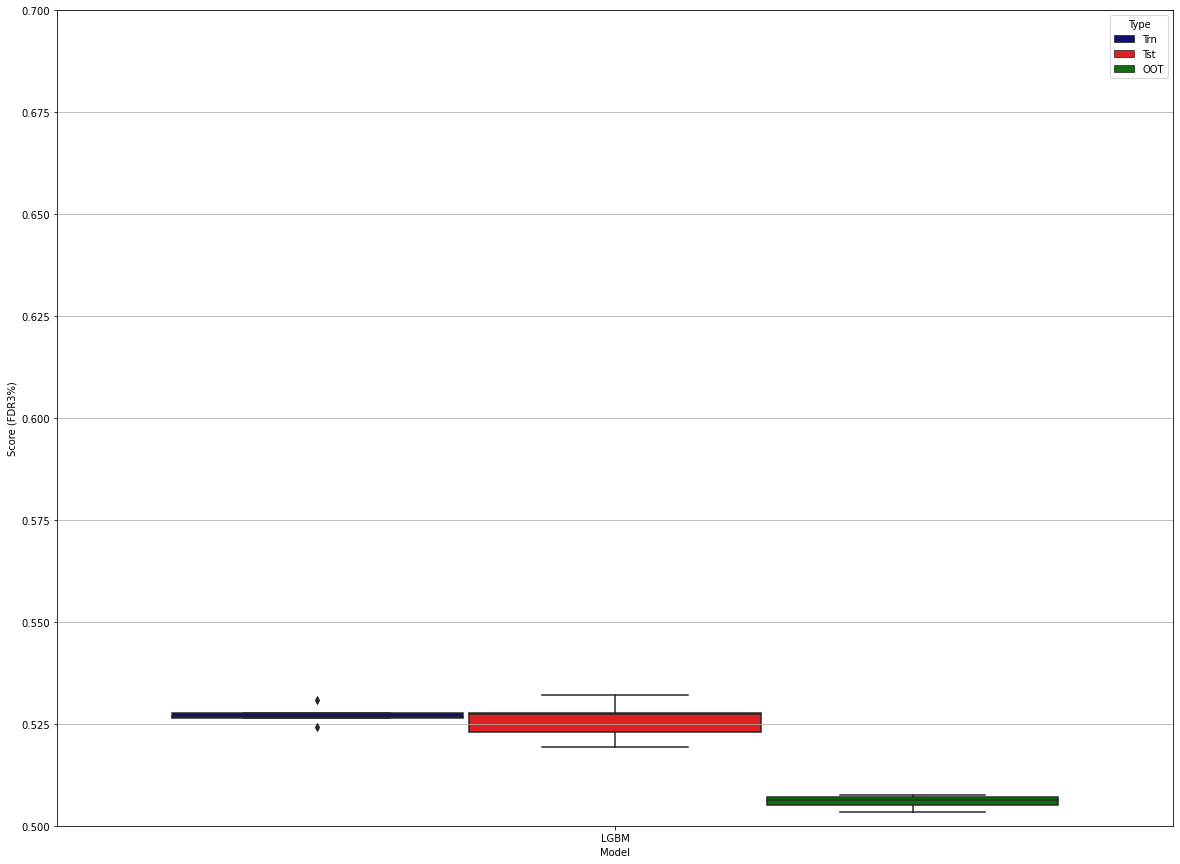

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [46]:
print('duration: ', datetime.now() - start_time)

duration:  0:09:54.733310


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [47]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = CatBoostClassifier(verbose=0, iterations=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5281664872622892 0.5263302249040044 0.5025146689019279
1 0.5290961125685667 0.5274785970726319 0.5062866722548198
2 0.5293908509125386 0.5267581955729896 0.5054484492875104
3 0.5234093637454982 0.5382104976883328 0.5054484492875104
4 0.5296158908699294 0.5271232876712328 0.5054484492875104
5 0.5233412322274882 0.5393888421642837 0.5054484492875104
6 0.5277044854881267 0.5276642136822023 0.5062866722548198
7 0.5298560302100542 0.5236343051231248 0.5058675607711651
8 0.5326230096971148 0.5172413793103449 0.5050293378038558
9 0.5246604717655469 0.5339053418212012 0.5050293378038558
10 0.5270078180525942 0.5307152875175316 0.5054484492875104
11 0.5289768662055807 0.5258215962441315 0.5062866722548198
12 0.5306634787806336 0.5238879736408567 0.5033528918692373
13 0.5245882213532409 0.5350336322869955 0.5071248952221291
14 0.5312947921643574 0.5226960110041265 0.5054484492875104
15 0.533213644524237 0.5164293537787513 0.5054484492875104
16 0.5304574543730742 0.5228355281591482 0.50670578

In [48]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [49]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)


,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,predicted,Fraud
882693,-3.280209,1.918606,17.021802,22.183093,18.625719,19.688532,-3.053486,19.326303,20.412515,-6.485123,16.952897,-7.379127,17.066277,0.999898,1.0
885388,-3.280209,1.918606,19.874549,25.889030,21.743745,22.981527,-3.053486,22.562122,23.826715,-6.663398,19.794915,-7.580705,19.925848,0.999887,1.0
948787,-3.280209,1.918606,14.169054,18.477156,15.507693,16.395538,-3.053486,17.708394,18.705415,-6.039433,14.110880,-6.875182,14.206705,0.999851,1.0
980888,-3.270118,1.918606,18.448175,24.036061,20.184732,21.335030,-3.043947,20.944212,22.119615,-8.490723,18.373906,-9.646880,18.496062,0.999743,1.0
854173,-3.280209,-0.093321,15.595428,20.330125,17.066706,18.042035,-3.053486,17.708394,18.705415,-0.579742,15.531889,-0.701855,15.636491,0.999725,1.0
884916,-3.280209,-0.093321,14.169054,18.477156,15.507693,16.395538,-3.053486,16.090484,16.998315,0.200213,14.110880,0.180049,14.206705,0.999725,1.0
854757,-3.280209,-0.093321,19.874549,25.889030,21.743745,22.981527,-3.053486,22.562122,23.826715,-0.423751,19.794915,-0.525475,19.925848,0.999725,1.0
854694,-3.280209,-0.093321,18.448175,24.036061,20.184732,21.335030,-3.053486,20.944212,22.119615,-0.468320,18.373906,-0.575869,18.496062,0.999725,1.0
854167,-3.280209,-0.093321,14.169054,18.477156,15.507693,16.395538,-3.053486,16.090484,16.998315,-0.650647,14.110880,-0.782028,14.206705,0.999725,0.0
854280,-3.280209,-0.093321,17.021802,22.183093,18.625719,19.688532,-3.053486,19.326303,20.412515,-0.519746,16.952897,-0.634017,17.066277,0.999725,1.0


In [54]:
oot_sorted.to_csv('oot_sorted.csv')

In [50]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,509.0,1156.0,30.570571,69.429429,1665.0,509.0,1156.0,0.310163,48.449288,48.139124,0.440311
2,2.0,1665.0,1635.0,30.0,98.198198,1.801802,3330.0,2144.0,1186.0,1.306465,49.706622,48.400157,1.807757
3,3.0,1665.0,1641.0,24.0,98.558559,1.441441,4995.0,3785.0,1210.0,2.306422,50.712490,48.406067,3.128099
4,4.0,1665.0,1648.0,17.0,98.978979,1.021021,6660.0,5433.0,1227.0,3.310645,51.424979,48.114334,4.427873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1655.0,10.0,99.399399,0.600601,159833.0,157485.0,2348.0,95.964828,98.407376,2.442549,67.071976
97,97.0,1665.0,1654.0,11.0,99.339339,0.660661,161498.0,159139.0,2359.0,96.972707,98.868399,1.895692,67.460365
98,98.0,1665.0,1655.0,10.0,99.399399,0.600601,163163.0,160794.0,2369.0,97.981195,99.287510,1.306315,67.874209
99,99.0,1665.0,1659.0,6.0,99.639640,0.360360,164828.0,162453.0,2375.0,98.992121,99.538977,0.546856,68.401263


In [51]:
FDR3.to_csv('FDR3.csv')

In [52]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [53]:
print("duration: ", datetime.now() - start_time)

duration:  0:12:08.763484
